# Что такое пневмония?
**Пневмония — это воспалительное заболевание легких, поражающее в первую очередь небольшие воздушные мешочки, известные как альвеолы. Симптомы обычно включают некоторую комбинацию продуктивного или сухого кашля, боли в груди, лихорадки и затрудненного дыхания. Тяжесть состояния варьируется. Пневмония обычно вызывается инфекцией вирусами или бактериями и реже другими микроорганизмами, некоторыми лекарствами или состояниями, такими как аутоиммунные заболевания. Факторы риска включают муковисцидоз, хроническую обструктивную болезнь легких (ХОБЛ), астму, диабет, сердечную недостаточность, курение в анамнезе, плохую способность кашлять, например, после инсульта, и слабую иммунную систему. Диагноз часто ставится на основании симптомов и физического осмотра. Рентгенография грудной клетки, анализы крови и посев мокроты могут помочь подтвердить диагноз. Заболевание может быть классифицировано по месту его приобретения, например, внебольничная или больничная или связанная с оказанием медицинской помощи пневмония.**
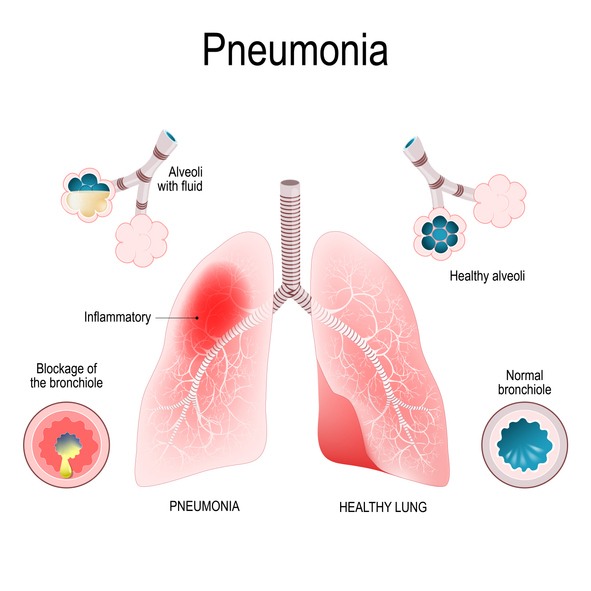

# Импортируем нужные зависимости

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np 
import pandas as pd 

2025-05-29 21:34:21.843768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748543661.862432   11840 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748543661.868019   11840 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748543661.882818   11840 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748543661.882837   11840 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748543661.882839   11840 computation_placer.cc:177] computation placer alr

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Описание датасета
**Датасет организован в 3 папки (train, test, val) и содержит подпапки для каждой категории изображений (пневмония/норма). Имеется 5863 рентгеновских снимков (JPEG) и 2 категории (пневмония/норма).
Рентгенограммы грудной клетки (переднезадняя проекция) были отобраны из ретроспективных когорт педиатрических пациентов в возрасте от одного до пяти лет из Медицинского центра для женщин и детей в Гуанчжоу. Все рентгенограммы грудной клетки выполнялись в рамках рутинного клинического ухода за пациентами.
Для анализа рентгеновских снимков грудной клетки все рентгенограммы грудной клетки изначально проверялись на контроль качества путем удаления всех некачественных или нечитаемых сканов. Затем диагнозы для изображений оценивались двумя врачами-экспертами, прежде чем они были допущены для обучения системы ИИ.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Загружаем датасет

In [4]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Визуализация данных и препроцессинг

<Axes: xlabel='count'>

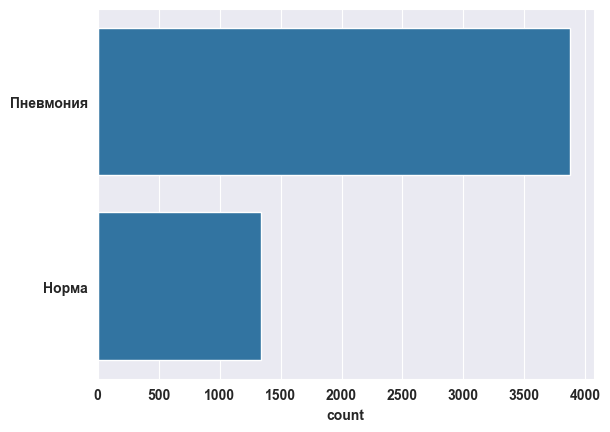

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Пневмония")
    else:
        l.append("Норма")
sns.set_style('darkgrid')
sns.countplot(l)        

**Данные несбалансированны. Чтобы увеличить количество обучающих примеров, мы будем использовать аугментацию данных.**

**Предварительный просмотр изображений обоих классов**

Text(0.5, 1.0, 'NORMAL')

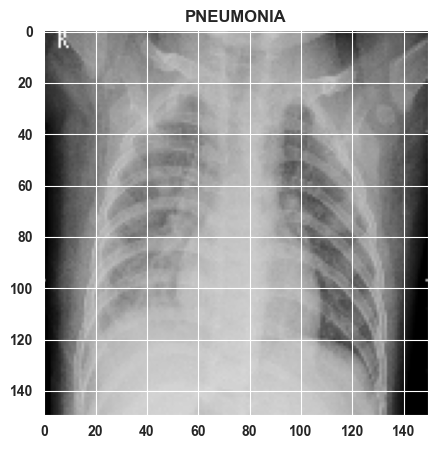

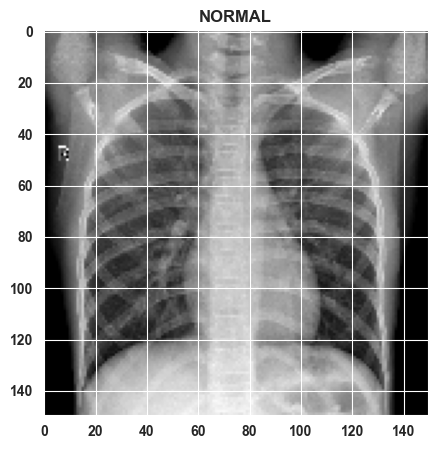

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**Выполним нормализацию оттенков серого, чтобы уменьшить влияние различий в освещении. Более того, CNN сходится быстрее на данных [0..1], чем на [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Аугментация данных
**Чтобы избежать проблемы переобучения, нам нужно искусственно расширить наш набор данных. Мы можем сделать ваш существующий набор данных еще больше. Идея состоит в том, чтобы изменить обучающие данные с помощью небольших преобразований, чтобы воспроизвести изменения.
Подходы, которые изменяют обучающие данные таким образом, что меняется представление массива, сохраняя при этом метку прежней, известны как методы дополнения данных. Некоторые популярные дополнения, которые используют люди, — это оттенки серого, горизонтальные перевороты, вертикальные перевороты, случайные кадры, цветовые колебания, переводы, вращения и многое другое.
Применив всего несколько таких преобразований к нашим обучающим данным, мы можем легко удвоить или утроить количество обучающих примеров и создать очень надежную модель.**

In [10]:

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True,  
        vertical_flip=False)  


datagen.fit(x_train)

Для аугментации данных я решил:
1. Случайным образом повернуть некоторые тренировочные изображения на 30 градусов
2. Случайным образом увеличить на 20% некоторые тренировочные изображения
3. Случайным образом сместить изображения по горизонтали на 10% ширины
4. Случайным образом сместить изображения по вертикали на 10% высоты
5. Случайным образом перевернуть изображения по горизонтали.

# Тренируем модель

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

/home/nosweat/tf/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1748543689.911117   11840 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1795 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


/home/nosweat/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748543693.235192   11929 service.cc:152] XLA service 0x7cb79c006760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748543693.235210   11929 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capability 6.1
2025-05-29 21:34:53.340992: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748543693.762512   11929 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-29 21:34:54.751076: I external/local_xla/xl

  3/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.6007 - loss: 3.9349

I0000 00:00:1748543701.767098   11929 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7965 - loss: 1.2152

2025-05-29 21:35:09.651099: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.16 = (f32[16,64,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,75,75]{3,2,1,0} %bitcast.726, f32[64,32,3,3]{3,2,1,0} %bitcast.733, f32[64]{0} %bitcast.735), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/nosweat/tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 21:35:09.899104: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially bug

163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.7967 - loss: 1.2113 - val_accuracy: 0.5000 - val_loss: 25.5264 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8916 - loss: 0.2859 - val_accuracy: 0.5000 - val_loss: 53.5572 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9233 - loss: 0.2216
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9233 - loss: 0.2216 - val_accuracy: 0.5000 - val_loss: 49.0836 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9370 - loss: 0.1624 - val_accuracy: 0.5000 - val_loss: 20.9252 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9526 - loss: 0.1300
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9526 - loss: 0.1300

In [14]:
print("Лосс модели равняется - " , model.evaluate(x_test,y_test)[0])
print("Точность модели равняется - " , model.evaluate(x_test,y_test)[1]*100 , "%")

2025-05-29 21:36:32.981746: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.16 = (f32[32,64,75,75]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,75,75]{3,2,1,0} %bitcast.726, f32[64,32,3,3]{3,2,1,0} %bitcast.733, f32[64]{0} %bitcast.735), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1_2/convolution" source_file="/home/nosweat/tf/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-29 21:36:33.354242: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially bug

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9059 - loss: 0.2617
Лосс модели равняется -  0.30842357873916626
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9059 - loss: 0.2617
Точность модели равняется -  89.74359035491943 %


# Анализ модели

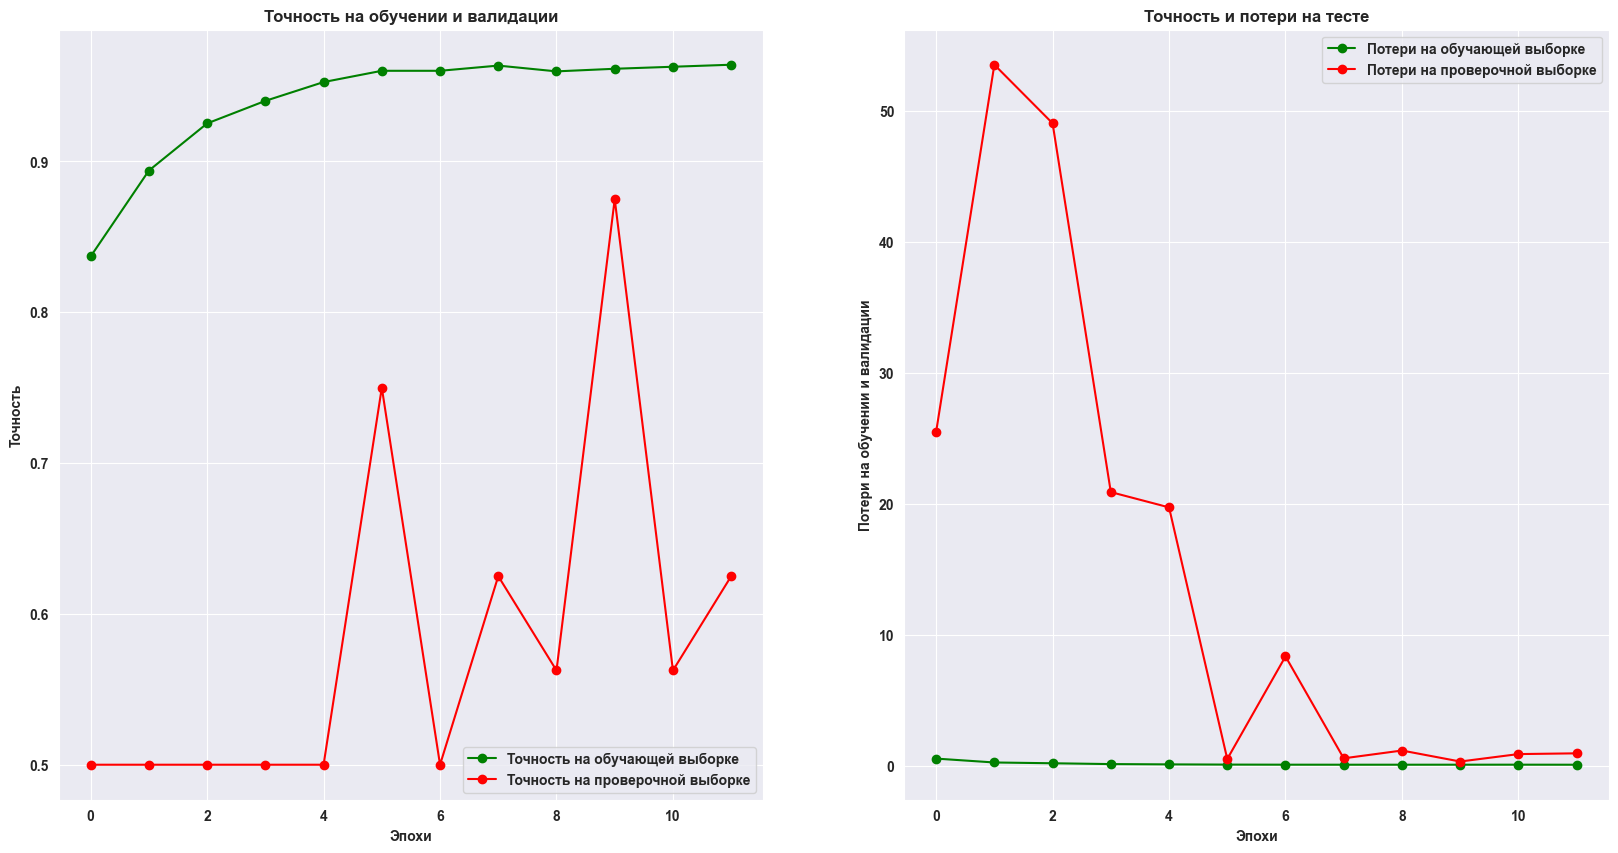

In [15]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Точность на обучающей выборке')
ax[0].plot(epochs, val_acc, 'ro-', label='Точность на проверочной выборке')
ax[0].set_title('Точность на обучении и валидации')
ax[0].legend()
ax[0].set_xlabel("Эпохи")
ax[0].set_ylabel("Точность")

ax[1].plot(epochs, train_loss, 'g-o', label='Потери на обучающей выборке')
ax[1].plot(epochs, val_loss, 'r-o', label='Потери на проверочной выборке')
ax[1].set_title('Точность и потери на тесте')
ax[1].legend()
ax[1].set_xlabel("Эпохи")
ax[1].set_ylabel("Потери на обучении и валидации")
plt.show()


In [16]:
predict_x = model.predict(x_test)  
classes_x = np.argmax(predict_x, axis=1)  #

print(classes_x[:15])

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
from sklearn.metrics import classification_report

y_pred = (predict_x > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred,
      target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.95      0.88      0.92       390
   Normal (Class 1)       0.83      0.92      0.87       234

           accuracy                           0.90       624
          macro avg       0.89      0.90      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [18]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[345,  45],
       [ 19, 215]])

In [19]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

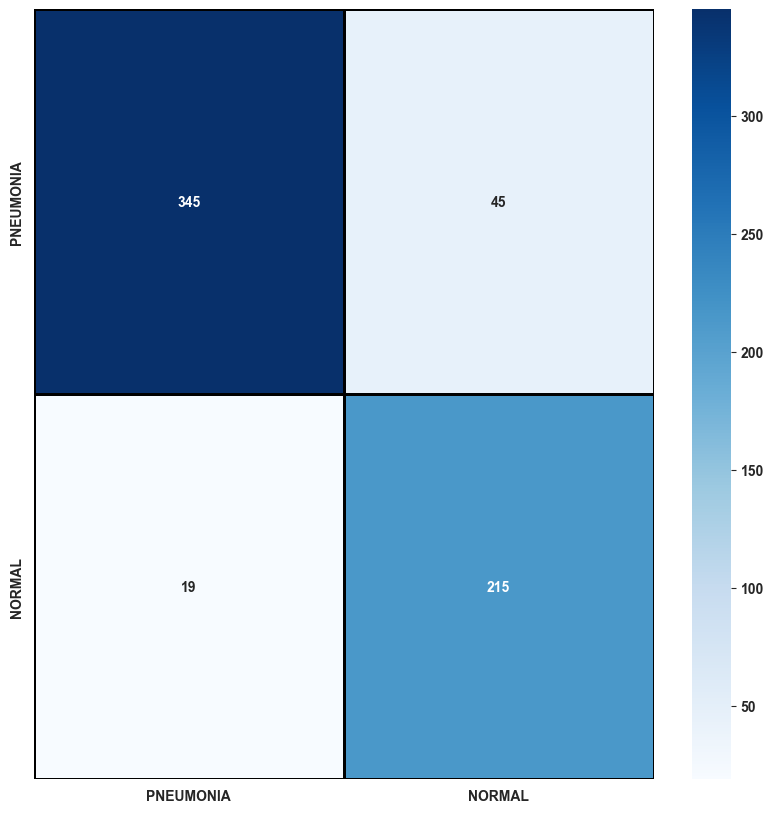

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [21]:
correct = np.nonzero(y_pred == y_test)[0]
incorrect = np.nonzero(y_pred != y_test)[0]

**Правильно предсказанные классы**

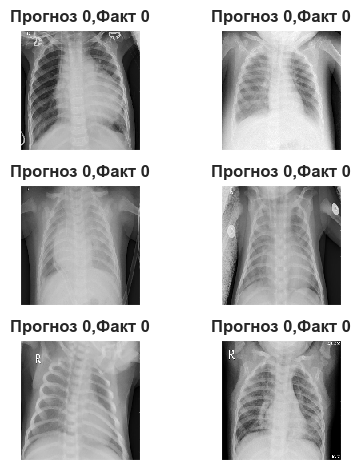

In [22]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Прогноз {},Факт {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Неправильно предсказанные классы**

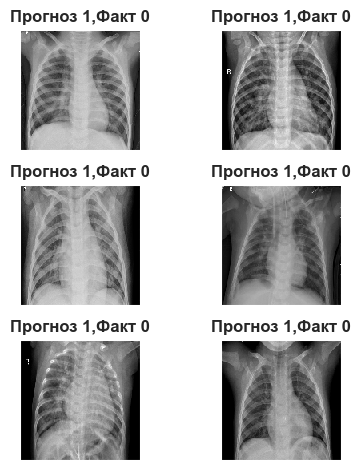

In [23]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Прогноз {},Факт {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [24]:
def preprocess_xray(img_path, img_size=150):
    """
    Load a chest X-ray from disk, convert to grayscale 150×150, normalize to [0,1],
    and reshape to (1, img_size, img_size, 1).
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32') / 255.0
    return img.reshape(1, img_size, img_size, 1)

def predict_xray(img_path, model, thresh=0.5):
    """
    Returns ('NORMAL' or 'PNEUMONIA', confidence).
    """
    x = preprocess_xray(img_path)
    prob = float(model.predict(x)[0][0])
    if prob > thresh:
        return 'NORMAL', prob
    else:
        return 'PNEUMONIA', 1 - prob


In [29]:
new_img = './chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'  
label, confidence = predict_xray(new_img, model)
print(f"Прогноз: {label} (точность: {confidence:.1%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
Прогноз: PNEUMONIA (точность: 83.7%)


In [30]:
new_img = './chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg' 
label, confidence = predict_xray(new_img, model, 0.4)
print(f"Прогноз: {label} (точность: {confidence:.1%})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Прогноз: NORMAL (точность: 58.3%)


In [31]:
model.save('pneumonia_cnn.keras')
print("Модель сохранена в pneumonia_cnn.keras")

Модель сохранена в pneumonia_cnn.keras
